# Tensorflow

---

# Library

In [1]:
import tensorflow as tf
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
import time
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

import numpy as np
import seaborn as sns
import time

import matplotlib.pyplot as plt
plt.style.use('ggplot')

We need to free gpu 

In [2]:
from numba import cuda

# free gpu
cuda.select_device(0)
cuda.close()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Load data
We load data which is preprocessed before.

In [3]:
import pickle
with open('../data/preprocessed_data.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

We need to check if gpu is available.

In [4]:
print("CUDA available:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))

CUDA available: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In TensorFlow, we prepare our data by converting it into `tf.Tensor` format for compatibility with TensorFlow operations. We then create `Dataset` objects for training, validation, and testing by pairing the input features and labels.

In [5]:
# convert data to tensor
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_tensor))

BATCH_SIZE = 128
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

print(f"Train Loader Batches: {len(train_dataset)}")
print(f"Validation Loader Batches: {len(val_dataset)}")
print(f"Test Loader Batches: {len(test_dataset)}")


Train Loader Batches: 313
Validation Loader Batches: 79
Test Loader Batches: 79


# Model design

We will construct the model with the following architecture:
- Hidden Layers: Two layers with 256 and 128 neurons, respectively.
- Activation Function: ReLU (Rectified Linear Unit).
- Optimizer: Adam.
- Batch Size: 128.
- Learning Rate: Initial value of 0.001, decreasing by 0.1% every 10 epochs.
- Maximum Iterations: 200.
- Early Stopping: Stop training if the loss does not improve within 10 epochs.

In [6]:
input_size = X_train.shape[1]

# hidden layers
model = tf.keras.models.Sequential([
  Dense(256, activation='relu', input_shape=(input_size,)),
  BatchNormalization(),
  Dense(128, activation='relu'),
  Dense(10, activation='softmax')
])                   

# # output layer
# model.add(Dense(10, activation='softmax'))     

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               786688    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 821,898
Trainable params: 821,386
Non-trainable params: 512
_________________________________________________________________


## Selecting Loss Function and Optimizer


We use the `Adam` optimizer with a learning rate of 0.001 to update the model's weights efficiently during training. The loss function, set `'categorical_crossentropy'` as `CrossEntropyLoss`.

In [7]:
# optimizer
optimizer = Adam(learning_rate=0.001)

loss_function = 'categorical_crossentropy'

## Model Training

We build learning rate scheduling function which reduces the learning rate by a factor of 0.1 every 10 epochs to improve convergence during traning.

In [8]:
def step_decay(epoch, lr):
    step_size = 10  
    gamma = 0.1     
    new_lr = lr * gamma if epoch > 0 and epoch % step_size == 0 else lr
    print(f"Epoch {epoch+1}: Learning Rate = {new_lr:.6f}") 
    return new_lr

lr_scheduler = LearningRateScheduler(step_decay)

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

Training process

In [9]:
# EarlyStopping  
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,            
    min_delta=0.001,        
    restore_best_weights=True
)

# Mark the start time
start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[lr_scheduler, early_stopping], 
    verbose=2  # display process
)
# Mark the end time
end_time = time.time()

Epoch 1: Learning Rate = 0.001000
Epoch 1/50
313/313 - 5s - loss: 1.7075 - accuracy: 0.3974 - val_loss: 1.8543 - val_accuracy: 0.3557 - lr: 0.0010 - 5s/epoch - 16ms/step
Epoch 2: Learning Rate = 0.001000
Epoch 2/50
313/313 - 2s - loss: 1.5243 - accuracy: 0.4636 - val_loss: 1.7273 - val_accuracy: 0.3943 - lr: 0.0010 - 2s/epoch - 5ms/step
Epoch 3: Learning Rate = 0.001000
Epoch 3/50
313/313 - 2s - loss: 1.4591 - accuracy: 0.4865 - val_loss: 1.6195 - val_accuracy: 0.4228 - lr: 0.0010 - 2s/epoch - 5ms/step
Epoch 4: Learning Rate = 0.001000
Epoch 4/50
313/313 - 1s - loss: 1.4046 - accuracy: 0.5066 - val_loss: 1.6452 - val_accuracy: 0.4124 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 5: Learning Rate = 0.001000
Epoch 5/50
313/313 - 1s - loss: 1.3625 - accuracy: 0.5195 - val_loss: 1.5794 - val_accuracy: 0.4397 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 6: Learning Rate = 0.001000
Epoch 6/50
313/313 - 1s - loss: 1.3268 - accuracy: 0.5339 - val_loss: 1.7501 - val_accuracy: 0.3981 - lr: 0.0010 - 1s/ep

In [10]:
# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 46.35 seconds


# Model Evaluation

79/79 [==============================] - 0s 3ms/step
Accuracy: 0.5310
Precision (macro): 0.5287
Recall (macro): 0.5310
F1-Score (macro): 0.5298


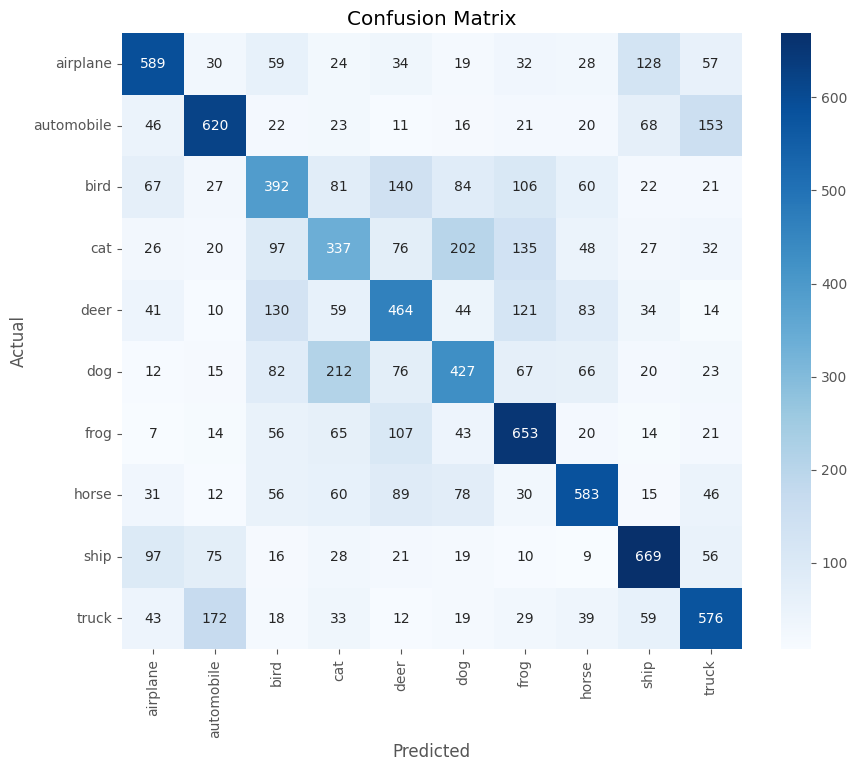

In [ ]:
# class in CIFAR-10 dataset
num_classes = 10
class_labels = ["airplane", "automobile", "bird", "cat", "deer", 
                "dog", "frog", "horse", "ship", "truck"]

y_pred_probs = model.predict(test_dataset)  
y_pred = np.argmax(y_pred_probs, axis=1)   
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)  

accuracy_metric = tf.keras.metrics.Accuracy()
accuracy_metric.update_state(y_true, y_pred)
tf_accuracy = accuracy_metric.result().numpy()

precision = []
recall = []

# Convert to one-hot encoding for class-wise metrics
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes)
y_pred_one_hot = tf.keras.utils.to_categorical(y_pred, num_classes)

for i in range(num_classes):
    precision_metric = tf.keras.metrics.Precision()
    recall_metric = tf.keras.metrics.Recall()
    
    precision_metric.update_state(y_true_one_hot[:, i], y_pred_one_hot[:, i])
    recall_metric.update_state(y_true_one_hot[:, i], y_pred_one_hot[:, i])
    
    precision.append(precision_metric.result().numpy())
    recall.append(recall_metric.result().numpy())

# Evaluate
precision = np.mean(precision)
recall = np.mean(recall)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {tf_accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-Score (macro): {f1_score:.4f}")

# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes)

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix.numpy(), annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Further Usage

In [12]:
from tensorflow.keras.models import load_model

model.save('tensorflow_model.h5')
loadedModel=tf.keras.models.load_model('tensorflow_model.h5')
loadedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               786688    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 821,898
Trainable params: 821,386
Non-trainable params: 512
_________________________________________________________________


1/1 [==============================] - 0s 60ms/step


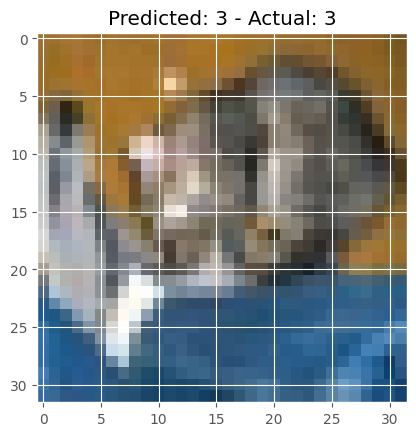

In [ ]:
single_image = X_test[0]
single_image = single_image.reshape(1, 3072) 

output = loadedModel.predict(single_image)

# show image
plt.imshow(single_image.reshape(32, 32, 3))
y_test = np.argmax(y_test, axis=1) 
plt.title(f'Predicted: {np.argmax(output[0])} - Actual: {y_test[0]}') 
plt.show()


GPU usage

In [14]:
import GPUtil
def mem_report():  
    GPUs = GPUtil.getGPUs()
    for i, gpu in enumerate(GPUs):
        print(f'GPU usage: {round(gpu.memoryUtil * 100, 2)}%')
mem_report()

GPU usage: 40.14%
